In [34]:
import os
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import minimize
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [36]:
levels = [
    [],                        # Level 1: Total
    ['state_id'],              # Level 2: State
    ['store_id'],              # Level 3: Store
    ['cat_id'],                # Level 4: Category
    ['dept_id'],               # Level 5: Department
    ['state_id', 'cat_id'],    # Level 6: State-Category
    ['state_id', 'dept_id'],   # Level 7: State-Department
    ['store_id', 'cat_id'],    # Level 8: Store-Category
    ['store_id', 'dept_id'],   # Level 9: Store-Department
    ['item_id'],               # Level 10: Item
    ['item_id', 'state_id'],   # Level 11: Item-State
    ['item_id', 'store_id']    # Level 12: Individual
]

def fit_distributions(data, key, distributions = [
    'norm',        
    't',           
    'gamma',       
    'beta',        
]):
    results = pd.DataFrame(columns=['level', 'group', 'distribution', 'parameters', 'p_value', 'significant', 'aic', 'bic'])

    for dist_name in distributions:
        dist = getattr(scipy.stats, dist_name)
        params = dist.fit(data)
        
        fitted_dist = dist(*params)
        _, ks_p_value = scipy.stats.kstest(data, fitted_dist.cdf)

        loglik = np.sum(fitted_dist.logpdf(data))
        
        n_params = len(params)
        n_samples = len(data)
        aic = 2 * n_params - 2 * loglik
        bic = n_params * np.log(n_samples) - 2 * loglik
        
        result = {
            'level': '_'.join(key.split('_')[:2]),
            'group': '_'.join(key.split('_')[2:]) if len(key.split('_')) > 2 else 'Total',
            'distribution': dist_name,
            'parameters': str(params),
            'p_value': ks_p_value,
            'significant': ks_p_value > 0.05,
            'aic': aic,
            'bic': bic
        }
        results = results.append(result, ignore_index=True)

    results = results.sort_values(['significant','aic','bic'], ascending=[False,True,True])
    
    return results

for level_idx, group_cols in enumerate(levels):
    if level_idx not in [1-1, 2-1, 3-1, 4-1, 5-1, 10-1]:
        continue

    print(f"\nProcessing Level {level_idx+1}")
    df = pd.read_csv(f'../data/preprocessed/agg_df_level_{level_idx+1}.csv')
    
    if not group_cols: # Level 1
        data = df['sales_sum']
        dist_results = fit_distributions(data, f'level_{level_idx+1}')

        dist_results.to_excel(f'../result/distribution_fitting/distribution_fit_level_{level_idx+1}.xlsx', index=False)
    
    else: # Level 2~12
        for group_name, group_data in df.groupby(group_cols):
            group_key = '_'.join(map(str, group_name)) if isinstance(group_name, tuple) else str(group_name)
            
            dist_results = fit_distributions(group_data['sales_sum'], f'level_{level_idx+1}_{group_key}')
            dist_results.to_excel(f'../result/distribution_fitting/distribution_fit_level_{level_idx+1}_{group_key}.xlsx', index=False)


Processing Level 1

Processing Level 2

Processing Level 3

Processing Level 4

Processing Level 5

Processing Level 10


Processing Level 1
Processing Level 2
Processing Level 3
Processing Level 4
Processing Level 5
Processing Level 10


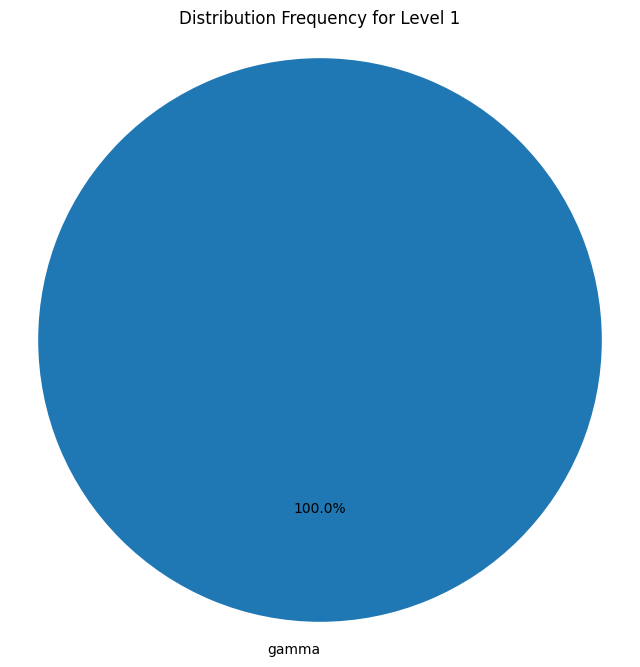

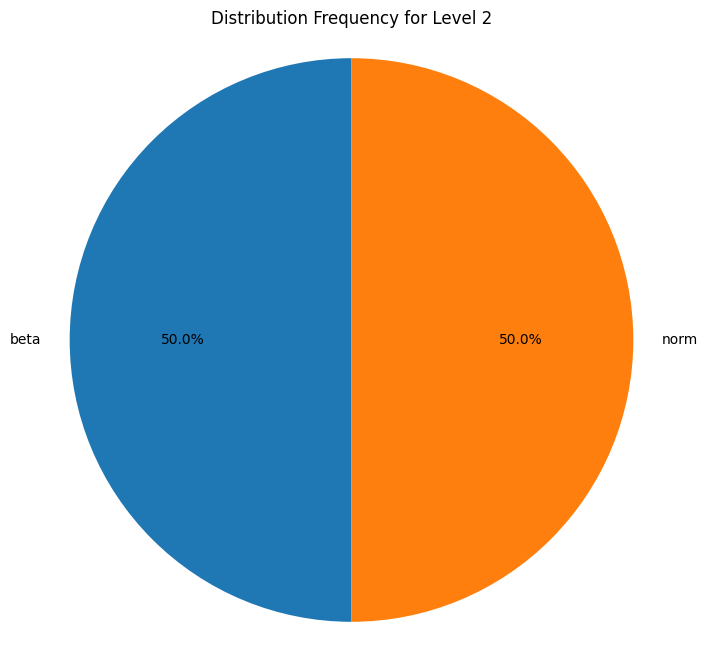

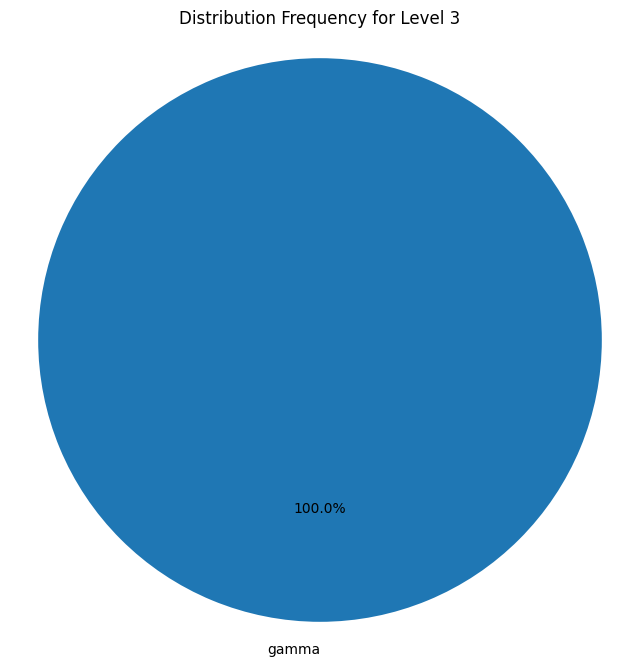

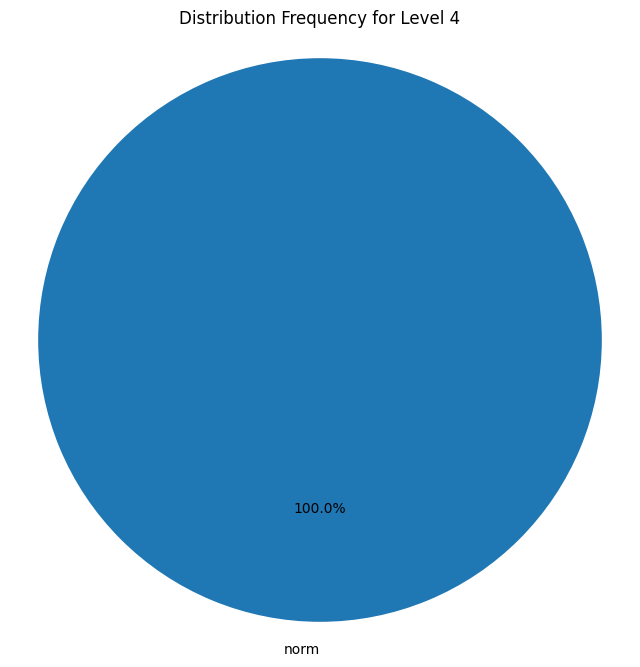

In [ ]:
def process_level_files(level_idx):
    input_dir = f'../result/distribution_fitting/'
    files = [f for f in os.listdir(input_dir) if f.startswith(f'distribution_fit_level_{level_idx+1}') and f.endswith('.xlsx')]

    distributions = []
    for file in files:
        file_path = os.path.join(input_dir, file)
        df = pd.read_excel(file_path)
        
        significant_data = df[df['significant'] == True]
        if not significant_data.empty:
            best_dist = significant_data.iloc[0]['distribution']
            if best_dist is not None:
                distributions.append(best_dist)
    
    return distributions

def plot_distribution_frequencies():
    level_distributions = {}
    for level_idx in [1, 2, 3, 4, 5, 10]:
        print(f"Processing Level {level_idx}")
        distributions = process_level_files(level_idx)
        level_distributions[level_idx] = distributions

    for level_idx, distributions in level_distributions.items():
        if distributions:
            plt.figure(figsize=(8, 8))
            unique_dists, counts = np.unique(distributions, return_counts=True)
            
            plt.pie(counts, labels=unique_dists, autopct='%1.1f%%', startangle=90)
            plt.title(f'Distribution Frequency for Level {level_idx}')
            plt.axis('equal')
            plt.show()

plot_distribution_frequencies()